<a href="https://colab.research.google.com/github/Samin765/DD2430_Project/blob/main/CLIP_prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Constants
Change these to fit your needs

In [12]:
# Are you developing locally or on google colab?
COLAB = False

# path kaggle will download to
HM_DATA_PATH = "/content/drive/MyDrive/dd2430/data/" if COLAB else "./data/"

# path tourch.save and .load will use
PTH_SAVE_PATH = "/content/drive/MyDrive/dd2430/pth/" if COLAB else "./pth/"

# False if you have already downloaded once
DOWNLOAD_FROM_KAGGLE = False

# False if you have already created and saved a .pth file to PTH_SAVE_PATH
CREATE_NEW_DATASET = False 

# train, test, val set size. Should sum to 1
SET_SIZES = {
    "train": 0.8,
    "test": 0.1,
    "val": 0.1,
}

# samples per class in uniform dataset
N_SAMPLES = 10

# Imports

In [13]:
import os
import random

from tqdm import tqdm
if COLAB:
    from google.colab import files, drive
import gdown

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import transformers

In [14]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available(): # For apple silicon 
    device = 'mps'

print("Using device: ", device)

Using device:  mps


# Download data

In [15]:
if COLAB:
    drive.mount('/content/drive')

In [16]:
if DOWNLOAD_FROM_KAGGLE:
    !pip install kaggle
    files.upload()

    os.makedirs('/root/.kaggle', exist_ok=True)
    !cp kaggle.json /root/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json

    %cd HM_DATA_PATH

    !kaggle competitions download -c h-and-m-personalized-fashion-recommendations
    !unzip -q h-and-m-personalized-fashion-recommendations.zip

#Dataset

In [17]:
from datasets import HMDataset2, UniformHMDataset

## Create new dataset
This will create a new dataset and save it as a .pth to google drive.

In [18]:
if CREATE_NEW_DATASET:
    dataset = HMDataset2(
        articles_csv = HM_DATA_PATH + 'articles.csv',
        image_dir = HM_DATA_PATH + 'images',
        main_class = 'garment_group_name',
        model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device),
        processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    )

    # data per class
    n_samples = N_SAMPLES

    # you can also set all to n_samples then set the ones you want to 0
    for exclude_subclass in ['Unknown', 'Special Offers', 'some other']:
        dataset.counts[exclude_subclass]=n_samples

    # Create uniform dataset
    image_emb, labels, images = dataset.get_n_of_each(n_samples)

    data_to_save = {
        'image_embedding': image_emb,
        'class_text': labels,
        'images': images,
    }

    os.makedirs(PTH_SAVE_PATH, exist_ok=True)
    torch.save(data_to_save, f'{PTH_SAVE_PATH}HM_data_{n_samples}.pth')

# Load data from Google Drive
If you already have the HM data and .pth saved in google drive, this is where the actual code/program begins.

Remember to change the constants at the top so you don't download and/or create a new dataset next time.

In [19]:
n_samples = N_SAMPLES
file_to_load = f"HM_data_{n_samples}.pth"

loaded_data = torch.load(f'{PTH_SAVE_PATH}{file_to_load}')

image_emb = loaded_data['image_embedding']
labels = loaded_data['class_text']
images = loaded_data['images']

dataset = UniformHMDataset(image_emb, labels , images)

/var/folders/h9/8cph72z15mjbyx6lk2517c_m0000gn/T/ipykernel_23768/891266091.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(f'{PTH_SAVE_PATH}{fil

# Split data into train, test, and val set
Use `dataset_train`, `dataset_test`, and `dataset_val`.

In [20]:
# dividing the data in equal parts to the three sets
combined = sorted(zip(labels, image_emb, images), key=lambda x: x[0])
labels, image_emb, images = zip(*combined)

train_labels, train_image_emb, train_images = [], [], []
test_labels, test_image_emb, test_images = [], [], []
val_labels, val_image_emb, val_images = [], [], []

for i in range(0, len(combined) - 1, n_samples):
    labels_sub = labels[i : i + n_samples]
    image_emb_sub = image_emb[i : i + n_samples]
    images_sub = images[i : i + n_samples]

    s = lambda t: int(float(len(labels_sub)) * SET_SIZES[t])

    train_labels.extend(labels_sub[:s("train")])
    train_image_emb.extend(image_emb_sub[:s("train")])
    train_images.extend(images_sub[:s("train")])

    test_labels.extend(labels_sub[s("train"):s("train") + s("test")])
    test_image_emb.extend(image_emb_sub[s("train"):s("train") + s("test")])
    test_images.extend(images_sub[s("train"):s("train") + s("test")])

    val_labels.extend(labels_sub[s("train") + s("test"):])
    val_image_emb.extend(image_emb_sub[s("train") + s("test"):])
    val_images.extend(images_sub[s("train") + s("test"):])

# shuffle the data in each set
def shuffle_set(labels, image_emb, images):
    combined = list(zip(labels, image_emb, images))
    random.shuffle(combined)
    return zip(*combined)

train_labels, train_image_emb, train_images = shuffle_set(train_labels, train_image_emb, train_images)
test_labels, test_image_emb, test_images = shuffle_set(test_labels, test_image_emb, test_images)
val_labels, val_image_emb, val_images = shuffle_set(val_labels, val_image_emb, val_images)

# create the datasets
dataset_train = UniformHMDataset(train_image_emb, train_labels, train_images)
dataset_test = UniformHMDataset(test_image_emb, test_labels, test_images)
dataset_val = UniformHMDataset(val_image_emb, val_labels, val_images)

# checking
print(len(labels), len(dataset_train.labels), len(dataset_test.labels), len(dataset_val.labels))
print(dataset_train.labels)

190 152 19 19
('Swimwear', 'Shoes', 'Blouses', 'Woven/Jersey/Knitted mix Baby', 'Blouses', 'Blouses', 'Jersey Basic', 'Knitwear', 'Jersey Fancy', 'Accessories', 'Under-, Nightwear', 'Trousers Denim', 'Shorts', 'Woven/Jersey/Knitted mix Baby', 'Dresses Ladies', 'Outdoor', 'Jersey Fancy', 'Knitwear', 'Socks and Tights', 'Under-, Nightwear', 'Knitwear', 'Blouses', 'Trousers Denim', 'Accessories', 'Socks and Tights', 'Outdoor', 'Blouses', 'Swimwear', 'Dressed', 'Shoes', 'Dressed', 'Accessories', 'Shoes', 'Swimwear', 'Shirts', 'Shorts', 'Shorts', 'Skirts', 'Shorts', 'Trousers Denim', 'Blouses', 'Knitwear', 'Accessories', 'Dresses/Skirts girls', 'Outdoor', 'Jersey Fancy', 'Dresses/Skirts girls', 'Dresses Ladies', 'Socks and Tights', 'Dresses/Skirts girls', 'Jersey Fancy', 'Shirts', 'Socks and Tights', 'Under-, Nightwear', 'Knitwear', 'Trousers', 'Accessories', 'Socks and Tights', 'Under-, Nightwear', 'Dresses Ladies', 'Shoes', 'Knitwear', 'Accessories', 'Knitwear', 'Outdoor', 'Accessories', 

#Coding

# Evaluate

In [21]:
model = transformers.CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = transformers.CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.feature_extractor.do_rescale = False # make sure image values: False=> [0-1] and True=> [0,255]

/opt/homebrew/Caskroom/miniconda/base/envs/ds-proj/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ds-proj/lib/python3.12/site-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [22]:
num_soft_prompts = 3
soft_prompts = nn.Parameter(torch.zeros(num_soft_prompts, model.text_projection.in_features), requires_grad=True)
#randn or zeros
optimizer = torch.optim.Adam([soft_prompts], lr=1e-3) # note that we here specify soft_prompts to tune

criterion = torch.nn.CrossEntropyLoss()
dataloader = DataLoader(dataset, batch_size=40, shuffle=False) # do not shuffle for eval

In [23]:
# functions for clip text and image embeddings, forward pass etc
# remember to import this again if you change something
import model_functions

In [24]:
# varius function that doesn't fit into model_functions or datasets
# for example displaying images 
import utils

**Baseline model and untuned softprompt**


obs,compare so that the modified transformer gets same result if num_soft = 0 yes!

  0%|          | 0/5 [00:00<?, ?it/s]

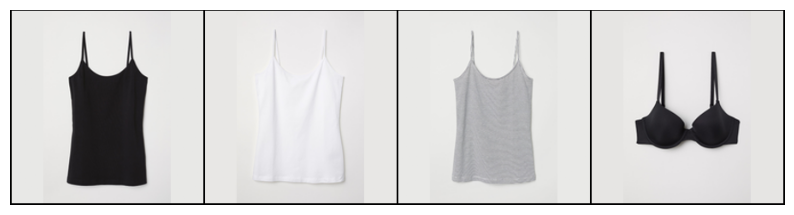

100%|██████████| 5/5 [00:01<00:00,  4.69it/s]

[13, 13, 13, 1, 1, 1, 17, 17, 17, 17, 17, 13, 13, 1, 1, 13, 13, 13, 13, 13, 7, 7, 7, 7, 17, 4, 4, 4, 4, 4, 4, 1, 1, 17, 7, 7, 7, 7, 7, 7, 4, 4, 17, 17, 17, 1, 1, 1, 15, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 11, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 9, 8, 8, 8, 8, 8, 11, 11, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 16, 2, 2, 2, 2, 2, 2, 2, 11, 11, 11, 11, 0, 0, 8, 8, 8, 8, 8, 16, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 15, 15, 15, 2, 2, 2, 11, 11, 11, 6, 6, 6, 6, 6, 10, 10, 10, 10, 6, 6, 6, 6, 6, 16, 16, 16, 16, 14, 14, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 5, 14, 12, 5, 5, 5, 12, 12, 12, 12, 12, 12, 12, 12, 12]
tensor([13, 13, 13,  1,  1,  1,  3, 17,  1,  3,  1,  5,  5,  5, 15, 13,  3,  3,
        15,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  1,  1, 15,  1,  5,
        13,  5,  5,  5,  4,  4,  1, 12,  9,  1,  1,  1, 15,  5, 13, 13, 13,  5,
         5, 13,  5,  4,  4, 11, 18, 18,  1, 18,  1,  1, 18, 18,  1, 18,  1,  8,
         8,  5,  5,

In [25]:
show_image = True
all_predictions_baseline = []
all_predictions_soft_untuned = []
all_labels= []
with torch.no_grad():
    for batch_nr, (image_embeds, labels, images) in enumerate(tqdm(dataloader)):
        text = [' '+i for i in dataset.classes] # for prediction
        #text = ['An image of a '+i for i in labels] # for training
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #use or not
        # baseline
        text_embeds = model_functions.get_text_emb(model, processor, text)
        logits_per_image1, loss = model_functions.apply_clip(text_embeds, image_embeds, model)
        probs1 = logits_per_image1.softmax(dim=-1).cpu().numpy()
        # softprompts

        text_embeds = model_functions.get_text_emb_soft(model, processor, text, soft_prompts)

        logits_per_image2, loss = model_functions.apply_clip(text_embeds, image_embeds, model)
        probs2 = logits_per_image2.softmax(dim=-1).cpu().numpy()

        if show_image and batch_nr%40==0:
            images = utils.return_normal(images, processor, 4, True)
            #print(dataset.classes)
            #print(probs1.round(decimals=3))
            #print('Base, then soft')
            #print(probs2.round(decimals=3))

        predicted_class_base = logits_per_image1.argmax(dim=-1)
        predicted_class_soft_untuned = logits_per_image2.argmax(dim=-1)

        all_predictions_baseline.append(predicted_class_base)
        all_predictions_soft_untuned.append(predicted_class_soft_untuned)
        for lab in labels:
            all_labels.append(dataset.class_to_id[lab])


all_predictions_baseline=torch.cat(all_predictions_baseline).cpu()
all_predictions_soft_untuned=torch.cat(all_predictions_soft_untuned).cpu()

print(all_labels)
print(all_predictions_baseline)

correct_base = all_predictions_baseline==torch.tensor(all_labels).cpu()
correct_soft_unt = all_predictions_soft_untuned==torch.tensor(all_labels).cpu()
print(f'\n Accuracy baseline {100*correct_base.sum()/correct_base.shape[0]} %')
print(f'Accuracy Soft prompt untuned {100*correct_soft_unt.sum()/correct_soft_unt.shape[0]} %')

**Finetuning**

Performance decreases if we add untuned soft prompts, now we finetune

In [26]:
show_image = True
#print(model)#https://github.com/search?q=repo%3Ahuggingface%2Ftransformers%20CLIPModel&type=code
model.train()
loss_list = []
batch_size = 40
epochs = 400
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for batch_nr, (image_embeds, labels, images) in enumerate(dataloader):
        optimizer.zero_grad()
        images.to(model.device)
        #text = ['An image of a '+i for i in dataset.classes] # for prediction, can use what we want
        text = [''+i for i in labels] # for training, must use 1-1 map
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #SLOW
        text_embeds = model_functions.get_text_emb_soft(model, processor, text, soft_prompts)
        logits_per_image, loss = model_functions.apply_clip(text_embeds, image_embeds, model, train=True)
        loss.backward()
        optimizer.step()
        #print(soft_prompts.grad) to see that back prop works, is none otherwise
        running_loss +=loss.item()
    loss_list.append(running_loss)

torch.save(soft_prompts, 'soft_prompts.pth')

  4%|▍         | 17/400 [00:18<06:46,  1.06s/it]

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, epochs+1)), loss_list, label='Training Loss')
# Adding labels and title
plt.title('Training Loss Over Datapoints')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Evaluate performance**

In [ ]:
all_labels= []
all_predictions_soft = []
with torch.no_grad():
    for batch_nr, (image_embeds, labels, images) in enumerate(tqdm(dataloader)):
        text = [''+i for i in dataset.classes] # for eval
        #image_embeds, _ = get_image_emb(model, processor, return_normal(images, processor, 0, False)) #use or not
        #text_embeds = get_text_emb_soft(model, processor, text, soft_prompts)
        text_embeds = model_functions.get_text_emb_soft(model, processor, text, soft_prompts)
        logits_per_image2, loss = model_functions.apply_clip(text_embeds, image_embeds, model)
        predicted_class_soft = logits_per_image2.argmax(dim=-1)
        all_predictions_soft.append(predicted_class_soft)
        for lab in labels:
            all_labels.append(dataset.class_to_id[lab])
all_predictions_soft=torch.cat(all_predictions_soft).cpu()
correct_soft = all_predictions_soft==torch.tensor(all_labels).cpu()

In [ ]:
print(f'\nOf {max(all_labels)} classes random is {1/max(all_labels)}%')
print(f'Accuracy baseline {100*correct_base.sum()/correct_base.shape[0]} %')
print(f'Accuracy Soft prompt untuned {100*correct_soft_unt.sum()/correct_soft_unt.shape[0]} %')
print(f'Accuracy Soft prompt {100*correct_soft.sum()/correct_soft.shape[0]} %')
from sklearn.metrics import classification_report
print(classification_report(all_predictions_soft, all_labels))
print(dataset.class_to_id)